In [39]:
import os
os.getcwd()

'/home/g0bi/g0bi/GenKI/notebook'

In [40]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

sc.settings.verbosity = 0

In [3]:
import GenKI as gk
from GenKI.preprocesing import build_adata
from GenKI.dataLoader import DataLoader
from GenKI.train import VGAE_trainer
from GenKI import utils

%load_ext autoreload
%autoreload 2

In [4]:
# Import STRINGdb for PPI network models and Networkx for visualisation and potential graph analysis
import stringdb
import networkx as nx

In [5]:
# Libraries for data wrangling on the adata object
from scipy.sparse import csr_matrix
from scipy.sparse import issparse

Loading the CALM dataset with the 7000 HVGs:

# CALM Original analysis on Brain snRNA-seq dataset

In [6]:
adata = sc.read("PD_7000.h5ad")
adata

AnnData object with n_obs × n_vars = 41392 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'cell_ontology', 'barcode', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'cell_ontology_colors', 'dendrogram_cell_ontology', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patient_colors', 'pca', 'predicted_doublet_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

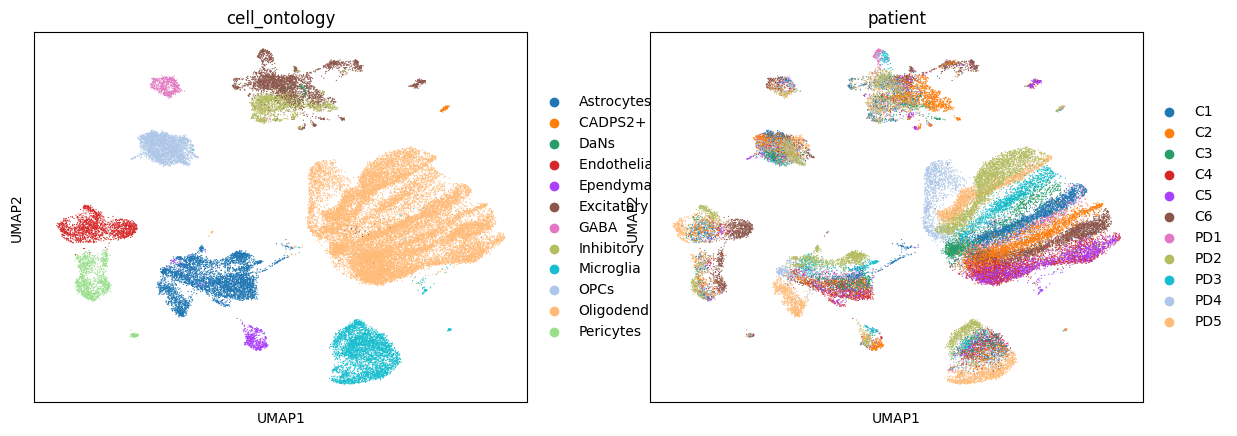

In [7]:
sc.pl.umap(adata, color = ["cell_ontology", "patient"])

In [8]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,patient,cell_ontology,barcode,n_genes,doublet_score,predicted_doublet,leiden,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
barcode,,,,,,,,,,,,,,,,,,
AAACCCACACATTGTG.1_1,SeuratProject,8356,3129,PD3,Oligodendrocytes,AAACCCACACATTGTG.1_1,3129,0.027381,False,0,776,6.655440,644.669060,6.470287,19.734265,31.746875,49.605628,79.313551
AAACCCAGTAAGATTG.1_1,SeuratProject,16859,5511,PD3,Excitatory,AAACCCAGTAAGATTG.1_1,5511,0.094040,False,8,1895,7.547502,1140.337335,7.039956,11.601435,19.842008,32.342934,55.979600
AAACGAACACCGCTGA.1_1,SeuratProject,10770,3732,PD3,Oligodendrocytes,AAACGAACACCGCTGA.1_1,3732,0.039017,False,0,942,6.849066,676.708518,6.518717,18.401516,29.749469,46.135963,74.305685
AAACGAAGTGCTTATG.1_1,SeuratProject,2895,1691,PD3,Microglia,AAACGAAGTGCTTATG.1_1,1691,0.016008,False,12,689,6.536692,930.320813,6.836604,14.654381,25.092866,42.705610,79.132879
AAACGAATCAATCTCT.1_1,SeuratProject,3763,1868,PD3,Oligodendrocytes,AAACGAATCAATCTCT.1_1,1868,0.019231,False,14,472,6.159095,560.389854,6.330416,23.108961,37.313600,57.923505,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGTTCACTG.1_11,SeuratProject,4327,1996,PD4,Oligodendrocytes,TTTGGTTAGTTCACTG.1_11,1996,0.082956,False,5,494,6.204558,571.217995,6.349520,22.756225,37.927565,59.426484,100.000000
TTTGGTTGTGACTCTA.1_11,SeuratProject,3520,1830,PD4,Oligodendrocytes,TTTGGTTGTGACTCTA.1_11,1830,0.055367,False,2,447,6.104793,555.595530,6.321839,22.955207,38.191143,59.716554,100.000000
TTTGTTGAGCCGCACT.1_11,SeuratProject,10065,3552,PD4,Oligodendrocytes,TTTGTTGAGCCGCACT.1_11,3552,0.067183,False,5,855,6.752270,661.996914,6.496770,19.444742,31.396594,48.404660,77.696629


In [7]:
adata_ctl = adata[(adata.obs["patient"].str.startswith("C")) ]
adata_ctl

View of AnnData object with n_obs × n_vars = 22418 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'cell_ontology', 'barcode', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'cell_ontology_colors', 'dendrogram_cell_ontology', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patient_colors', 'pca', 'predicted_doublet_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
parkadata = adata[(adata.obs["patient"].str.startswith("P"))]
parkadata

View of AnnData object with n_obs × n_vars = 18974 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'cell_ontology', 'barcode', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'cell_ontology_colors', 'dendrogram_cell_ontology', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patient_colors', 'pca', 'predicted_doublet_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

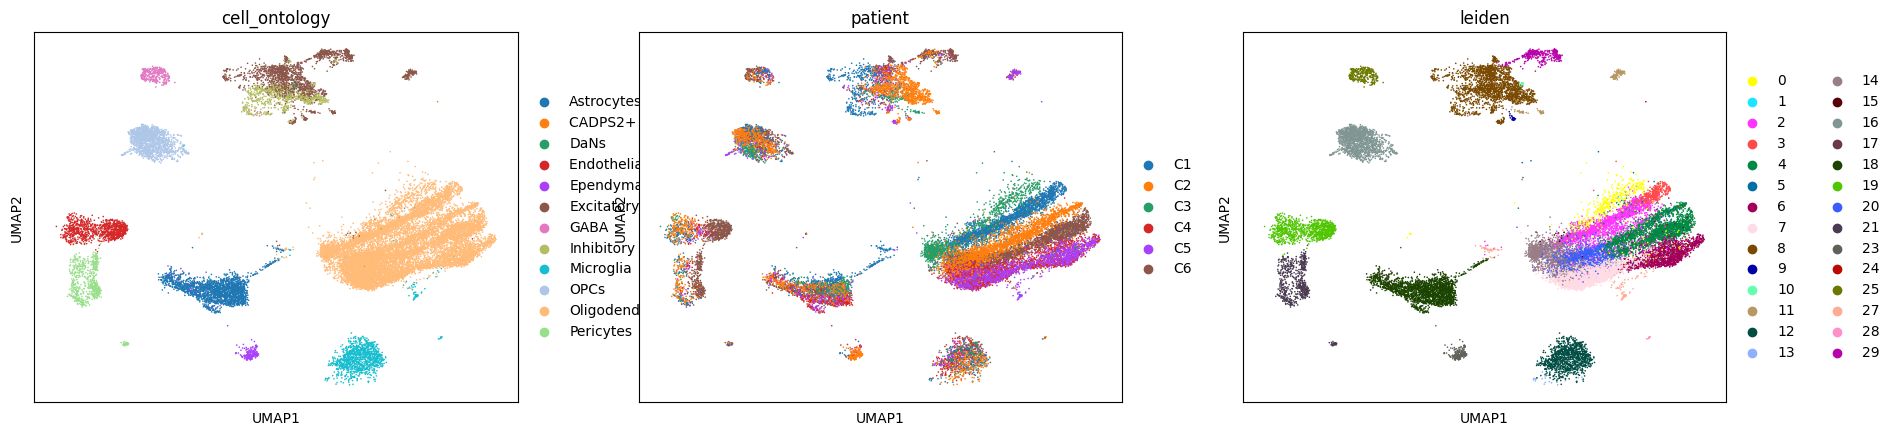

In [17]:
sc.pl.umap(adata_ctl, color = ["cell_ontology", "patient", "leiden"])

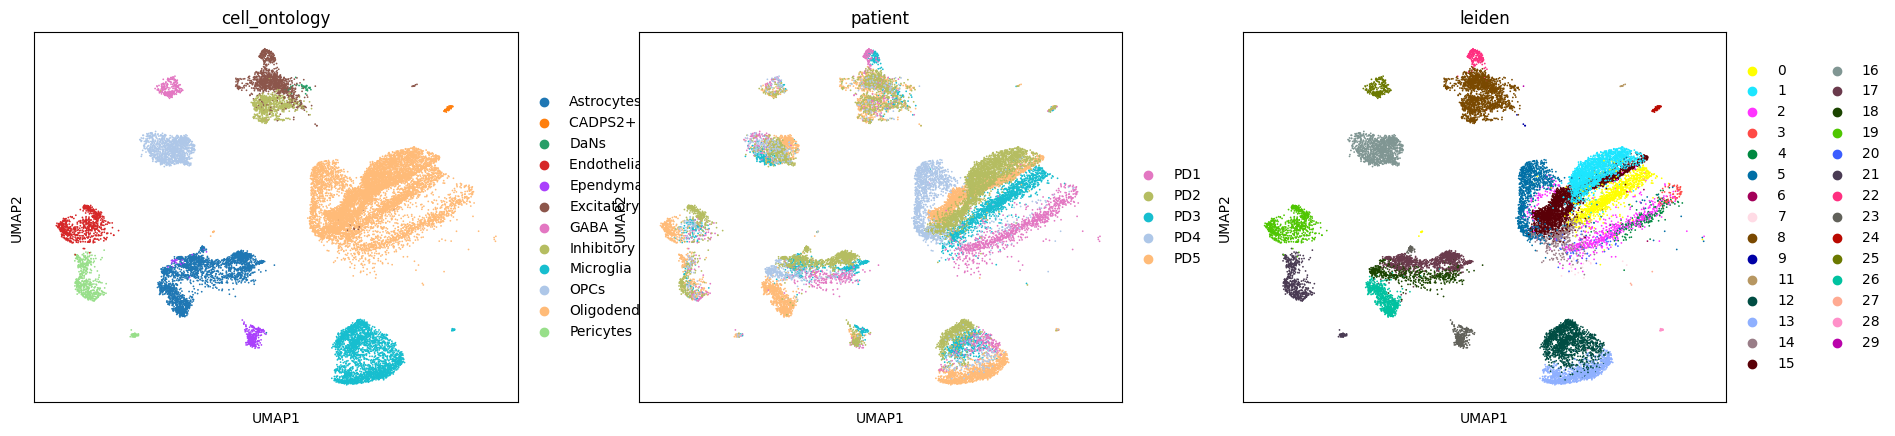

In [15]:
sc.pl.umap(parkadata, color = ["cell_ontology", "patient", "leiden"])

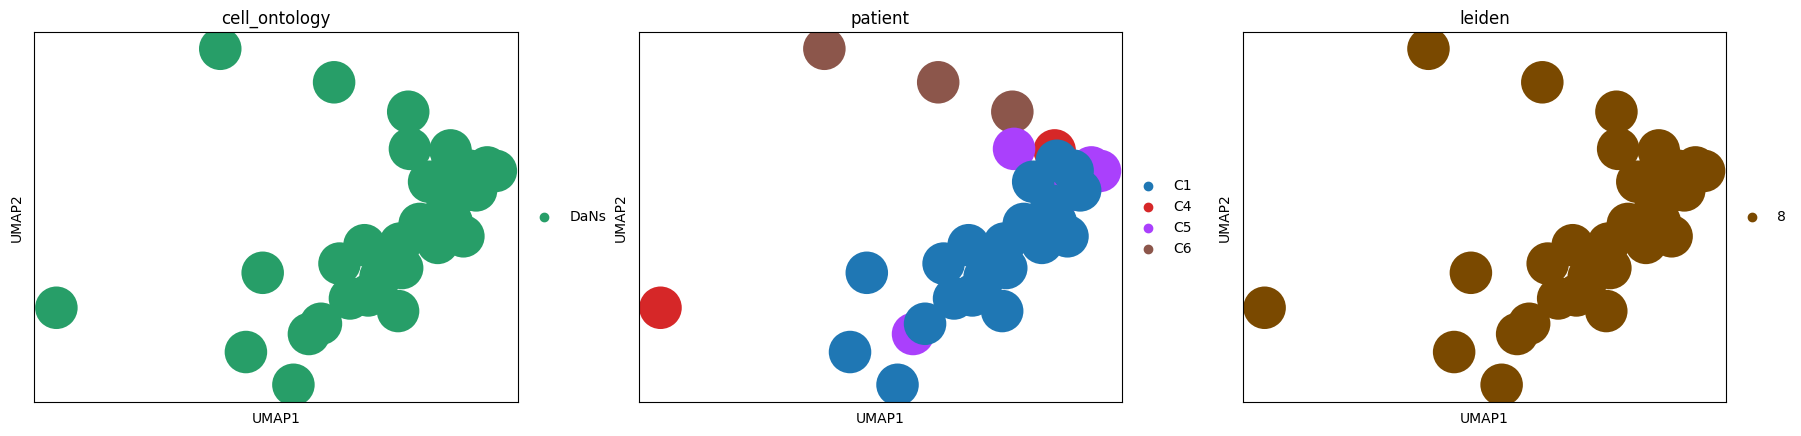

In [9]:
sc.pl.umap(dan, color = ["cell_ontology", "patient", "leiden"])

In [8]:
# adata pre-processing to prepare for input in the GenKI tool
adata_ctl.layers["norm"] = adata_ctl.X.copy()

/var/folders/hr/f3msc_bs3z53n3_m4c4ry6tc0000gn/T/ipykernel_12279/1097313641.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_ctl.layers["norm"] = adata_ctl.X.copy()


In [11]:
# The adata.X should be normalised-scaled AND in sparse matrix format!
if not issparse(adata_downsampled.X):
    sparse_matrix = csr_matrix(adata_downsampled.X)
    adata_downsampled.X = sparse_matrix
    print("Converted adata.X to a sparse matrix.")
else:
    print("adata.X is already a sparse matrix.")

NameError: name 'adata_downsampled' is not defined

In [9]:
dan = adata_ctl[adata_ctl.obs["cell_ontology"] == "DaNs" ]
dan

View of AnnData object with n_obs × n_vars = 32 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'cell_ontology', 'barcode', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'cell_ontology_colors', 'dendrogram_cell_ontology', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patient_colors', 'pca', 'predicted_doublet_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances'

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_

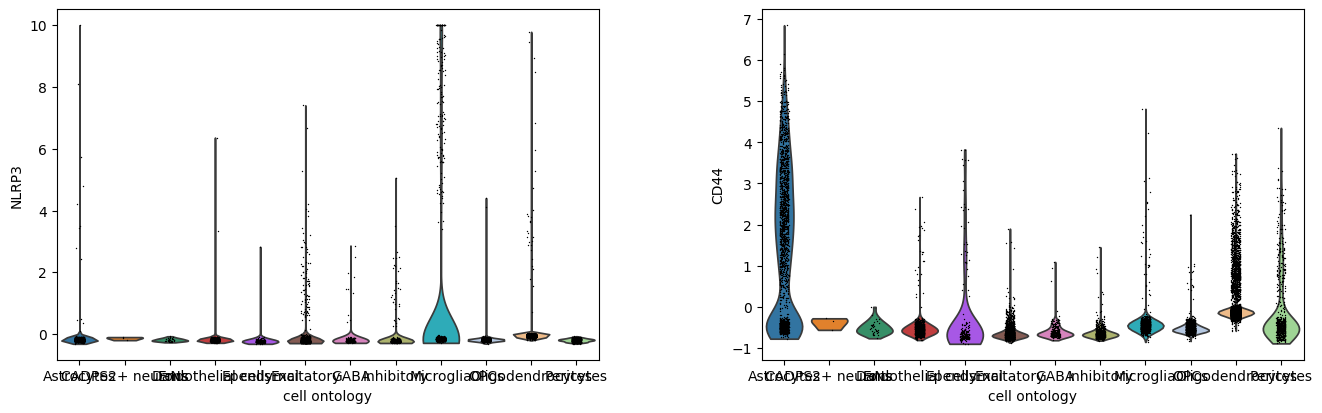

In [13]:
sc.pl.violin(adata_ctl, ["NLRP3", "CD44"], groupby="cell_ontology")

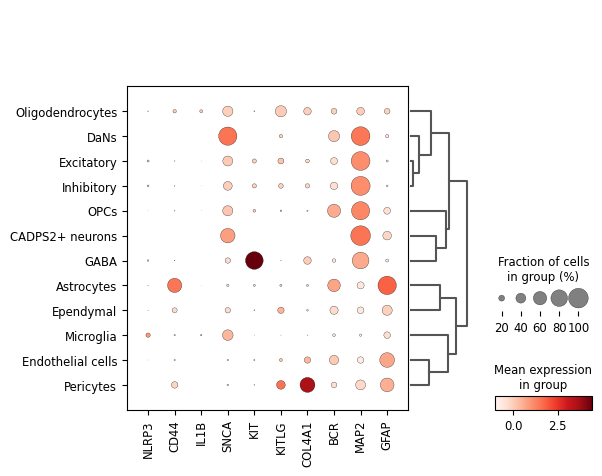

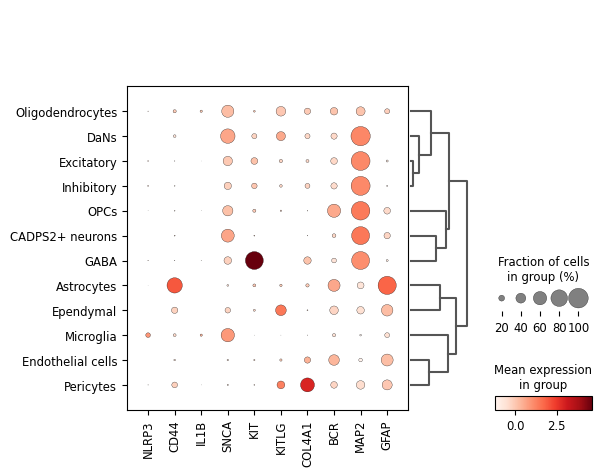

In [36]:
# Nilotinib signature + increased molecules from the paper
sc.pl.dotplot(adata_ctl,["NLRP3", "CD44", "IL1B", "SNCA", "KIT", "KITLG", "COL4A1", "BCR", "MAP2", "GFAP"], "cell_ontology", dendrogram=True)
sc.pl.dotplot(parkadata,["NLRP3", "CD44", "IL1B", "SNCA", "KIT", "KITLG", "COL4A1", "BCR", "MAP2", "GFAP"], "cell_ontology", dendrogram=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_

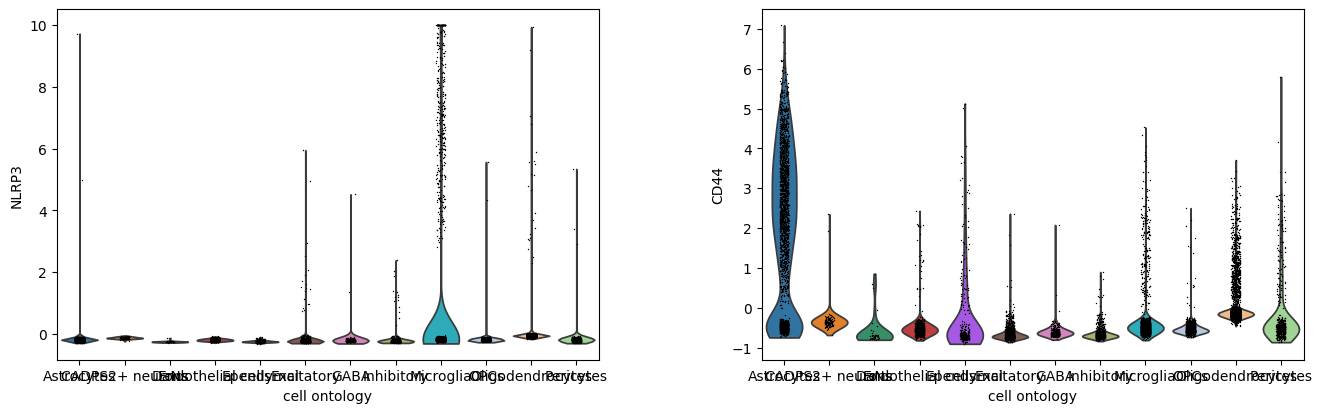

In [16]:
sc.pl.violin(parkadata, ["NLRP3", "CD44"], groupby="cell_ontology")

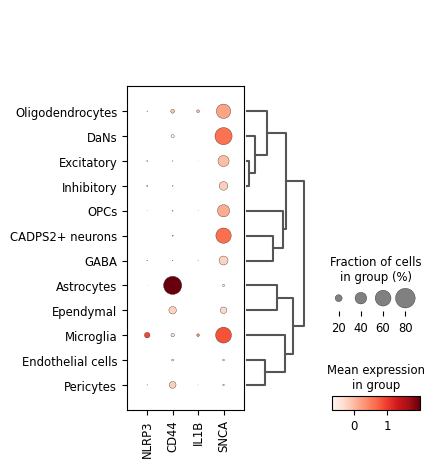

In [21]:
sc.pl.dotplot(parkadata,["NLRP3", "CD44", "IL1B", "SNCA"], "cell_ontology", dendrogram=True)

In [38]:
# This is a large dataset, you can downsample it using the following function:
import numpy as np

# Set the target number of cells
target_cells = 6300 # this is arbitrary, change it accordingly

# Calculate the proportion to sample
sample_fraction = target_cells / parkadata.n_obs

# Perform downsampling
adata_downsampled = parkadata[np.random.choice(parkadata.obs_names, size=target_cells, replace=False)]

In [39]:
adata_downsampled

View of AnnData object with n_obs × n_vars = 6300 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'cell_ontology', 'barcode', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'cell_ontology_colors', 'dendrogram_cell_ontology', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patient_colors', 'pca', 'predicted_doublet_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [42]:
adata_downsampled.layers["norm"] = adata_downsampled.X.copy()

/var/folders/hr/f3msc_bs3z53n3_m4c4ry6tc0000gn/T/ipykernel_3181/2433999081.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_downsampled.layers["norm"] = adata_downsampled.X.copy()


In [ ]:
# Assemble the data_wrapper which controls aspects of the digital KO experimen
data_wrapper =  DataLoader(
                adata_downsampled, # adata object
                target_gene = ["KIT"], # KO gene name
                target_cell = None, # obsname for cell type, if none use all
                obs_label = "cell_ontology", # colname for genes
                GRN_file_dir = "GRNs", # folder name for GRNs
                rebuild_GRN = True, # whether build GRN by pcNet
                pcNet_name = "pcNet_example_CALM_Nilo1", # GRN file name
                verbose = True, # whether verbose
                n_cpus = 11, # multiprocessing
                )

data_wt = data_wrapper.load_data()
data_ko = data_wrapper.load_kodata()

use all the cells (6300) in adata
build GRN


2024-11-19 22:17:48,079	INFO worker.py:1786 -- Started a local Ray instance.


ray init, using 11 CPUs


In [14]:
# Assemble the data_wrapper which controls aspects of the digital KO experimen
data_wrapper =  DataLoader(
                dan, # adata object
                target_gene = ["SIAH1"], # KO gene name
                target_cell = None, # obsname for cell type, if none use all
                obs_label = "cell_ontology", # colname for genes
                GRN_file_dir = "GRNs", # folder name for GRNs
                rebuild_GRN = True, # whether build GRN by pcNet
                pcNet_name = "pcNet_example_CALM_dan", # GRN file name
                verbose = True, # whether verbose
                n_cpus = 11, # multiprocessing
                )

data_wt = data_wrapper.load_data()
data_ko = data_wrapper.load_kodata()

use all the cells (32) in adata
build GRN


2024-10-16 12:35:31,509	INFO worker.py:1786 -- Started a local Ray instance.


ray init, using 11 CPUs
execution time of making pcNet: 49.34 s
GRN has been built and saved in "GRNs/pcNet_example_CALM_dan.npz"
init completed



In [57]:

hyperparams = {
    "epochs": 300,  # Increased epochs for more training
    "lr": 5e-3,  # Adjusted learning rate
    "beta": 5e-4,  # Increased beta for stronger regularization
    "seed": 8096  # Trying a different seed
}


log_dir = None

sensei = VGAE_trainer(
    data_wt,
    epochs=hyperparams["epochs"],
    lr=hyperparams["lr"],
    log_dir=log_dir,
    beta=hyperparams["beta"],
    seed=hyperparams["seed"],
    verbose=False,
)

In [58]:
# %%timeit
sensei.train()

In [17]:
sensei.save_model('model_example_Calm_dan')

save model parameters to model/model_example_Calm_dan.th


In [59]:
# get distance between wt and ko

z_mu_wt, z_std_wt = sensei.get_latent_vars(data_wt)
z_mu_ko, z_std_ko = sensei.get_latent_vars(data_ko)
dis = gk.utils.get_distance(z_mu_ko, z_std_ko, z_mu_wt, z_std_wt, by="KL")
print(dis.shape)

(7000,)


In [60]:
# raw ranked gene list

res_raw = utils.get_generank(data_wt, dis, rank=True)
res_raw.head(20)

,dis,rank
SIAH1,2.076981,1
HAT1,0.000023,2
PLEKHH2,0.000021,3
JUNB,0.000021,4
LRP10,0.000021,5
SLC8A1-AS1,0.000020,6
ATG16L2,0.000020,7
MED9,0.000020,8
PTBP1,0.000020,9
SALL3,0.000020,10


In [61]:
# if permutation test

null = sensei.pmt(data_ko, n=100, by="KL")
res = utils.get_generank(data_wt, dis, null,)
#                       save_significant_as = 'gene_list_example')
res

Permutating: 100%|████████████████████████████| 100/100 [00:50<00:00,  2.00it/s]


,dis,index,hit,rank
SIAH1,2.076981,5536,100,1
HAT1,0.000023,2059,99,2
PLEKHH2,0.000021,3299,99,3
JUNB,0.000021,4502,98,4
LRP10,0.000021,5607,98,5
...,...,...,...,...
IKZF1,0.000011,5296,96,176
PXDC1,0.000011,4334,96,177
TLR2,0.000011,2526,96,178
NIBAN2,0.000011,2493,96,179


In [62]:
res.head(20)

,dis,index,hit,rank
SIAH1,2.076981,5536,100,1
HAT1,0.000023,2059,99,2
PLEKHH2,0.000021,3299,99,3
JUNB,0.000021,4502,98,4
LRP10,0.000021,5607,98,5
SLC8A1-AS1,0.000020,6062,99,6
ATG16L2,0.000020,4257,99,7
MED9,0.000020,2760,99,8
PTBP1,0.000020,117,98,9
SALL3,0.000020,6666,98,10


Top 10 Pathways:
Series([], Name: description, dtype: object)


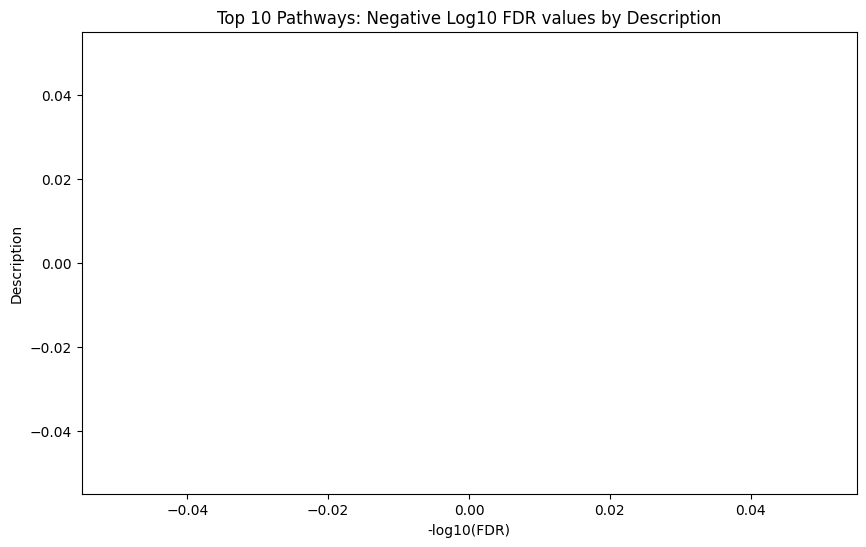

In [66]:
# Let's create a STRINGdb network of the targets affected by the Six2 digital KO on the DBiT-seq dataset
genes = list(res.index[1:20,])

string_ids = stringdb.get_string_ids(genes, species = 9606)   # human is 'species=9606'

# Performe pathway enrichment
enrichment_df = stringdb.get_enrichment(string_ids.queryItem, species = 9606)
enrichment_df
df = enrichment_df
sorted_df = df.sort_values(by='fdr', ascending=False)

# Select the top 10 pathways to visualise
top_10_pathways = sorted_df['description'].head(10)

print("Top 10 Pathways:")
print(top_10_pathways)

# Plotting negative log10 of FDR values against description to discern most significant pathways
plt.figure(figsize=(10, 6))
plt.barh(sorted_df['description'].head(10), -1 * sorted_df['fdr'].head(10).apply(lambda x: math.log10(x)))
plt.xlabel('-log10(FDR)')
plt.ylabel('Description')
plt.title('Top 10 Pathways: Negative Log10 FDR values by Description')
plt.show()

In [64]:
genes

['HAT1',
 'PLEKHH2',
 'JUNB',
 'LRP10',
 'SLC8A1-AS1',
 'ATG16L2',
 'MED9',
 'PTBP1',
 'SALL3',
 'PIEZO1',
 'PER2',
 'MYL12A',
 'PPIL6',
 'ZIC1',
 'SLC16A3',
 'TEX9',
 'IL17RB',
 'PTK2B',
 'TSPO']

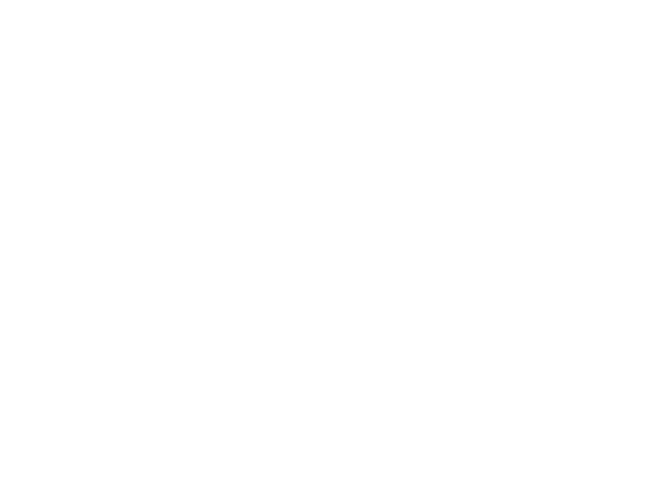

In [67]:
# Preparing visualization of STRINGdb network with Networkx
network_df = stringdb.get_network(string_ids.queryItem, species = 9606, required_score=400)
df = network_df
G = nx.Graph()
for index, row in df.iterrows():
    G.add_edge(row['preferredName_A'], row['preferredName_B'], weight=row['score'])

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10)

# Draw edge labels with weights
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

Hitting all neurons

In [13]:
adata_ctl.obs

,orig.ident,nCount_RNA,nFeature_RNA,patient,cell_ontology,barcode,n_genes,doublet_score,predicted_doublet,leiden,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
barcode,,,,,,,,,,,,,,,,,,
AAACCCAAGAGTTGCG.1_4,SeuratProject,16038,4677,C6,Oligodendrocytes,AAACCCAAGAGTTGCG.1_4,4677,0.037197,False,4,1167,7.063048,703.136192,6.556972,18.195693,29.311680,44.893442,71.035926
AAACCCAAGCTTTCTT.1_4,SeuratProject,8382,2909,C6,Oligodendrocytes,AAACCCAAGCTTTCTT.1_4,2909,0.053199,False,4,787,6.669498,676.013225,6.517691,19.046850,31.335584,48.896206,79.536962
AAACCCAAGTATAGAC.1_4,SeuratProject,2615,1424,C6,Oligodendrocytes,AAACCCAAGTATAGAC.1_4,1424,0.067300,False,2,387,5.961005,555.963510,6.322500,24.071376,40.335058,63.215474,100.000000
AAACCCACAGCAGGAT.1_4,SeuratProject,3882,2159,C6,Astrocytes,AAACCCACAGCAGGAT.1_4,2159,0.011243,False,18,808,6.695799,945.733643,6.853018,14.575073,24.636286,40.398770,72.351902
AAACCCAGTCGAGCTC.1_4,SeuratProject,5139,2073,C6,OPCs,AAACCCAGTCGAGCTC.1_4,2073,0.017610,False,16,756,6.629363,885.088537,6.786817,16.524112,28.704937,47.217913,79.805681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGATCGCCC.1_9,SeuratProject,6417,2759,C2,Excitatory,TTTGTTGAGATCGCCC.1_9,2759,0.074074,False,8,1096,7.000334,1088.594382,6.993561,13.320375,23.088305,38.048795,67.547572
TTTGTTGAGTCAGCCC.1_9,SeuratProject,2063,1182,C2,Oligodendrocytes,TTTGTTGAGTCAGCCC.1_9,1182,0.019137,False,14,324,5.783825,508.845480,6.234108,25.978935,44.117693,69.358756,100.000000
TTTGTTGCACAGTACT.1_9,SeuratProject,13534,4822,C2,Inhibitory,TTTGTTGCACAGTACT.1_9,4822,0.061329,False,8,1545,7.343426,1028.514032,6.936842,11.712957,19.948187,33.323720,59.519510


In [14]:
adata_ctl.obs["cell_ontology"].unique()

['Oligodendrocytes', 'Astrocytes', 'OPCs', 'Excitatory', 'Endothelial cells', ..., 'Pericytes', 'Microglia', 'DaNs', 'Ependymal', 'CADPS2+ neurons']
Length: 12
Categories (12, object): ['Astrocytes', 'CADPS2+ neurons', 'DaNs', 'Endothelial cells', ..., 'Microglia', 'OPCs', 'Oligodendrocytes', 'Pericytes']

In [13]:
# Subset adata_ctl to include DaNs, Cadps2, and excitatory cells ---- CADPS2+ neurons, GABA
dan = adata_ctl[
    # (adata_ctl.obs["cell_ontology"] == "DaNs") |
    # (adata_ctl.obs["cell_ontology"] == "Inhibitory") 
    # (adata_ctl.obs["cell_ontology"] == "Excitatory") |
    # (adata_ctl.obs["cell_ontology"] == "CADPS2+ neurons") |
    (adata_ctl.obs["cell_ontology"] == "GABA")
]
dan

View of AnnData object with n_obs × n_vars = 286 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'cell_ontology', 'barcode', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'cell_ontology_colors', 'dendrogram_cell_ontology', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patient_colors', 'pca', 'predicted_doublet_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances'

In [11]:
# This is a large dataset, you can downsample it using the following function:
import numpy as np

# Set the target number of cells
target_cells = 300 # this is arbitrary, change it accordingly

# Calculate the proportion to sample
sample_fraction = target_cells / dan.n_obs

# Perform downsampling
dan_s = dan[np.random.choice(dan.obs_names, size=target_cells, replace=False)]
dan_s

View of AnnData object with n_obs × n_vars = 300 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'cell_ontology', 'barcode', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'cell_ontology_colors', 'dendrogram_cell_ontology', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patient_colors', 'pca', 'predicted_doublet_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances'

In [14]:
# Assemble the data_wrapper which controls aspects of the digital KO experimen
data_wrapper =  DataLoader(
                dan, # adata object
                target_gene = ["SIAH1"], # KO gene name
                target_cell = None, # obsname for cell type, if none use all
                obs_label = "cell_ontology", # colname for genes
                GRN_file_dir = "GRNs", # folder name for GRNs
                rebuild_GRN = True, # whether build GRN by pcNet
                pcNet_name = "pcNet_example_CALM_dan_2", # GRN file name
                verbose = True, # whether verbose
                n_cpus = 15, # multiprocessing
                )

data_wt = data_wrapper.load_data()
data_ko = data_wrapper.load_kodata()

use all the cells (286) in adata
build GRN


2024-12-06 20:08:31,616	INFO worker.py:1786 -- Started a local Ray instance.


ray init, using 15 CPUs
execution time of making pcNet: 1228.38 s
GRN has been built and saved in "GRNs/pcNet_example_CALM_dan_2.npz"
init completed



In [20]:
# init trainer

# hyperparams = {"epochs": 100, 
#                "lr": 7e-4, 
#                "beta": 1e-4, 
#                "seed": 8096}
# log_dir=None 

hyperparams = {
    "epochs": 300,  # Increased epochs for more training
    "lr": 5e-3,  # Adjusted learning rate
    "beta": 5e-4,  # Increased beta for stronger regularization
    "seed": 8096  # Trying a different seed
}

sensei = VGAE_trainer(data_wt, 
                     epochs=hyperparams["epochs"], 
                     lr=hyperparams["lr"], 
                     log_dir=log_dir, 
                     beta=hyperparams["beta"],
                     seed=hyperparams["seed"],
                     verbose=False,
                     )

In [21]:
# %%timeit
sensei.train()

In [22]:
z_mu_wt, z_std_wt = sensei.get_latent_vars(data_wt)
z_mu_ko, z_std_ko = sensei.get_latent_vars(data_ko)
dis = gk.utils.get_distance(z_mu_ko, z_std_ko, z_mu_wt, z_std_wt, by="KL")
print(dis.shape)

(7000,)


In [18]:
# raw ranked gene list

res_raw = utils.get_generank(data_wt, dis, rank=True)
res_raw.head()

,dis,rank
SIAH1,7.145246e-03,1
OTX2-AS1,1.008042e-07,2
NYAP2,9.821054e-08,3
GALNT14,9.676749e-08,4
CPLX3,9.578509e-08,5


In [23]:
# raw ranked gene list

res_raw = utils.get_generank(data_wt, dis, rank=True)
res_raw.head()

,dis,rank
SIAH1,15.808974,1
CFH,0.000016,2
TRIM38,0.000016,3
MS4A6A,0.000016,4
TNFRSF10D,0.000016,5


In [19]:
null = sensei.pmt(data_ko, n=100, by="KL")
res = utils.get_generank(data_wt, dis, null,)
#                       save_significant_as = 'gene_list_example')
res

Permutating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


,dis,index,hit,rank
SIAH1,7.145246e-03,5536,100,1
RFX3-DT,8.626145e-08,6188,97,2
PDK4,7.132434e-08,24,96,3
KSR1,7.000386e-08,2762,96,4
ITPKB,5.967160e-08,2893,95,5


In [24]:
null = sensei.pmt(data_ko, n=100, by="KL")
res = utils.get_generank(data_wt, dis, null,)
#                       save_significant_as = 'gene_list_example')
res

Permutating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]


,dis,index,hit,rank
SIAH1,15.808974,5536,100,1
CFH,0.000016,4,100,2
TRIM38,0.000016,1418,100,3
MS4A6A,0.000016,1295,100,4
TNFRSF10D,0.000016,4668,100,5
...,...,...,...,...
GOLIM4,0.000007,4692,99,257
TTC6,0.000007,2692,95,258
GBP4,0.000007,3770,98,259
NOD1,0.000007,1157,98,260


In [26]:
res.head(50)

,dis,index,hit,rank
SIAH1,15.808974,5536,100,1
CFH,0.000016,4,100,2
TRIM38,0.000016,1418,100,3
MS4A6A,0.000016,1295,100,4
TNFRSF10D,0.000016,4668,100,5
RGL3,0.000016,5837,100,6
SMAD6,0.000016,2563,100,7
SLA,0.000015,3484,100,8
TNFRSF10B,0.000015,1770,100,9
TLR2,0.000015,2526,100,10


# Organoids HVG

In [6]:
adata = sc.read("organoids_SCT_hvg.h5ad")
adata

AnnData object with n_obs × n_vars = 5978 × 5000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'pearson_residuals_normalization', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'pearson_residuals', 'raw', 'sqrt_

In [7]:
adata.layers["norm"] = adata.X.copy()

In [9]:
# The adata.X should be normalised-scaled AND in sparse matrix format!
if not issparse(adata.X):
    sparse_matrix = csr_matrix(adata.X)
    adata.X = sparse_matrix
    print("Converted adata.X to a sparse matrix.")
else:
    print("adata.X is already a sparse matrix.")

Converted adata.X to a sparse matrix.


In [ ]:
data_wrapper =  DataLoader(
                adata, # adata object
                target_gene = ["KITLG"], # KO gene name
                target_cell = None, # obsname for cell type, if none use all
                obs_label = "leiden", # colname for genes
                GRN_file_dir = "GRNs", # folder name for GRNs
                rebuild_GRN = True, # whether build GRN by pcNet
                pcNet_name = "pcNet_example_CALM_Organoids", # GRN file name
                verbose = True, # whether verbose
                n_cpus = 11, # multiprocessing
                )

data_wt = data_wrapper.load_data()
data_ko = data_wrapper.load_kodata()

use all the cells (5978) in adata
build GRN


2025-02-08 10:46:49,390	INFO worker.py:1786 -- Started a local Ray instance.


ray init, using 11 CPUs


In [11]:
adata

AnnData object with n_obs × n_vars = 5978 × 5000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'pearson_residuals_normalization', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'pearson_residuals', 'raw', 'sqrt_